# Projet Spochify 

In [16]:
import pandas as pd

# Training
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Log transformation
import numpy as np

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

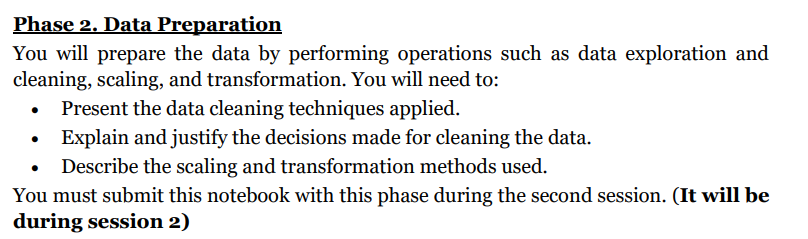

Pre-processing

Traitements fichier .csv

In [17]:
WINE_FILE_PATH = "Data/WineDataset.csv"
wine_df = pd.read_csv(WINE_FILE_PATH, header=0)
wine_df.head()

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [18]:
len(wine_df)

1290

In [19]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1290 non-null   object 
 1   Description                1286 non-null   object 
 2   Price                      1290 non-null   object 
 3   Capacity                   1290 non-null   object 
 4   Grape                      1275 non-null   object 
 5   Secondary Grape Varieties  488 non-null    object 
 6   Closure                    1279 non-null   object 
 7   Country                    1284 non-null   object 
 8   Unit                       1281 non-null   float64
 9   Characteristics            1253 non-null   object 
 10  Per bottle / case / each   1290 non-null   object 
 11  Type                       1285 non-null   object 
 12  ABV                        1281 non-null   object 
 13  Region                     1124 non-null   objec

### Data Cleaning

#### 1. Price

Here, we will only focus on price associated to one bottle and remove the other type of prices. Then, we apply a float conversion.

In [20]:
wine_df["Per bottle / case / each"].unique()

array(['per bottle', 'per case', 'each'], dtype=object)

In [21]:
# Remove non per bottle rows
wine_df = wine_df[~wine_df['Price'].str.contains(r'per case|each', case=False, na=False, regex=True)].reset_index(drop=True)

# Convert into float in a new column
wine_df['Price_clean'] = (
    wine_df['Price']
    .str.replace('£', '', regex=False)
    .str.replace(' per bottle', '', regex=False)
    .astype(float)
)

wine_df["Per bottle / case / each"].unique()

wine_df.drop('Per bottle / case / each', axis=1, inplace=True)
wine_df.drop('Price', axis=1, inplace=True)

#### 2. ABV

ABV (Alcool By Volume) needs only a float conversion. 

In [22]:
# Convert into float in a new column
wine_df['ABV_clean'] = wine_df['ABV'].str.extract(r'(\d+\.\d+)').astype(float)

wine_df.drop('ABV', axis=1, inplace=True)

#### 3. Grape

For the grape, we consider only wines with a known grape. Then this values are encoded.

In [23]:
# Number of rows to remove
print(wine_df['Grape'].isna().sum())

# Remove NaN values
wine_df.dropna(subset=['Grape'], inplace=True)

# Encode it
grape_encoded = pd.get_dummies(wine_df['Grape'], prefix='Grape')
wine_df = pd.concat([wine_df, grape_encoded], axis=1)
wine_df.drop('Grape', axis=1, inplace=True)

8


#### 4. Secondary Grape Varieties

As a lot of wines does not especially have a secondary grape variety, we choose to keep NaN rows for this columns, convert into "None" values. Encoding here is quite particular because we handle multiple varietes separated by ','.  

In [24]:
# Number of Nan rows
print(wine_df['Secondary Grape Varieties'].isna().sum())

# Convert NaN values
wine_df['Secondary Grape Varieties'] = wine_df['Secondary Grape Varieties'].fillna('None')

# Convert content into list
wine_df['Secondary Grape Varieties'] = wine_df['Secondary Grape Varieties'].apply(lambda x: [i.strip() for i in x.split(',')] if x != 'None' else [])

# Multilabel encoding
mlb = MultiLabelBinarizer()
secondary_encoded = pd.DataFrame(mlb.fit_transform(wine_df['Secondary Grape Varieties']),
                                 columns=[f'Secondary_{c}' for c in mlb.classes_])

wine_df = pd.concat([wine_df, secondary_encoded], axis=1)
wine_df.drop('Secondary Grape Varieties', axis=1, inplace=True)

# All encoded columns for grapes
print(wine_df.columns.tolist())
print(wine_df.shape)

785
['Title', 'Description', 'Capacity', 'Closure', 'Country', 'Unit', 'Characteristics', 'Type', 'Region', 'Style', 'Vintage', 'Appellation', 'Price_clean', 'ABV_clean', 'Grape_Agiorgitiko', 'Grape_Aglianico', 'Grape_Airen', 'Grape_Albarino', 'Grape_Alicante Bouschet', 'Grape_Aligoté', 'Grape_Alvarinho', 'Grape_Arinto', 'Grape_Assyrtiko', 'Grape_Bacchus', 'Grape_Barbera', 'Grape_Black Muscat', 'Grape_Cabernet Franc', 'Grape_Cabernet Sauvignon', 'Grape_Carignan', 'Grape_Carménère', 'Grape_Castelão ', 'Grape_Chardonnay', 'Grape_Chenin Blanc', 'Grape_Cinsault', 'Grape_Colombard', 'Grape_Cortese', 'Grape_Corvina', 'Grape_Dolcetto', 'Grape_Falanghina', 'Grape_Fernão Pires', 'Grape_Feteasca Alba', 'Grape_Fiano', 'Grape_Furmint', 'Grape_Gamay', 'Grape_Garganega', 'Grape_Garnacha', 'Grape_Gewürztraminer', 'Grape_Glera', 'Grape_Godello', 'Grape_Greco', 'Grape_Grenache', 'Grape_Grenache Blanc', 'Grape_Grillo', 'Grape_Grolleau', 'Grape_Gruner Veltliner', 'Grape_Huxelrebe', 'Grape_Inzolia', 'Grap

#### 5. Region, Style, Country, Type, Appellation and Characteristics

In [25]:
# -----------------------------
# 1. One-Hot Encoding
# -----------------------------
columns_to_encode = ['Region', 'Style', 'Country', 'Type', 'Appellation']

for col in columns_to_encode:
    wine_df[col] = wine_df[col].fillna('None')
    dummies = pd.get_dummies(wine_df[col], prefix=col)
    wine_df = pd.concat([wine_df, dummies], axis=1)
    wine_df.drop(col, axis=1, inplace=True)

# --------------------------------------
# 2. Multi-label Binarizer for 'Characteristics'
# --------------------------------------

# Convert into list
wine_df['Characteristics'] = wine_df['Characteristics'].fillna('None')
wine_df['Characteristics'] = wine_df['Characteristics'].apply(
    lambda x: [] if x == 'None' else [i.strip() for i in x.split(',')]
)

# MultiLabelBinarizer
mlb = MultiLabelBinarizer()
char_encoded = pd.DataFrame(
    mlb.fit_transform(wine_df['Characteristics']),
    columns=[f'Char_{c}' for c in mlb.classes_]
)

wine_df = pd.concat([wine_df, char_encoded], axis=1)
wine_df.drop('Characteristics', axis=1, inplace=True)

# All encoded columns for grapes
print(wine_df.columns.tolist())
print(wine_df.shape)

['Title', 'Description', 'Capacity', 'Closure', 'Unit', 'Vintage', 'Price_clean', 'ABV_clean', 'Grape_Agiorgitiko', 'Grape_Aglianico', 'Grape_Airen', 'Grape_Albarino', 'Grape_Alicante Bouschet', 'Grape_Aligoté', 'Grape_Alvarinho', 'Grape_Arinto', 'Grape_Assyrtiko', 'Grape_Bacchus', 'Grape_Barbera', 'Grape_Black Muscat', 'Grape_Cabernet Franc', 'Grape_Cabernet Sauvignon', 'Grape_Carignan', 'Grape_Carménère', 'Grape_Castelão ', 'Grape_Chardonnay', 'Grape_Chenin Blanc', 'Grape_Cinsault', 'Grape_Colombard', 'Grape_Cortese', 'Grape_Corvina', 'Grape_Dolcetto', 'Grape_Falanghina', 'Grape_Fernão Pires', 'Grape_Feteasca Alba', 'Grape_Fiano', 'Grape_Furmint', 'Grape_Gamay', 'Grape_Garganega', 'Grape_Garnacha', 'Grape_Gewürztraminer', 'Grape_Glera', 'Grape_Godello', 'Grape_Greco', 'Grape_Grenache', 'Grape_Grenache Blanc', 'Grape_Grillo', 'Grape_Grolleau', 'Grape_Gruner Veltliner', 'Grape_Huxelrebe', 'Grape_Inzolia', 'Grape_Jacquere', 'Grape_Lambrusco Grasparossa', 'Grape_Loureiro', 'Grape_Macabeo

#### 6. Drop NaN and useless columns

In [26]:
print(wine_df.isna().any(axis=1).sum())
wine_df.dropna(inplace=True)

21


In [27]:
wine_df.drop(columns=["Description", "Unit", "Capacity", "Closure", "Vintage"], inplace=True)
wine_df.head()

,Title,Price_clean,ABV_clean,Grape_Agiorgitiko,Grape_Aglianico,Grape_Airen,Grape_Albarino,Grape_Alicante Bouschet,Grape_Aligoté,Grape_Alvarinho,...,Char_Tobacco,Char_Toffee,Char_Tomato Leaf,Char_Tropical Fruit,Char_Vanilla,Char_Violet,Char_Walnut,Char_Watermelon,Char_Wet Stones,Char_White Pepper
0,"The Guv'nor, Spain",9.99,14.0,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Bread & Butter 'Winemaker's Selection' Chardon...,15.99,13.5,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",12.49,13.0,False,False,False,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Louis Latour Mâcon-Lugny 2021/22,17.99,13.5,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bread & Butter 'Winemaker's Selection' Pinot N...,15.99,13.5,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
len(wine_df)

1258

### Data training

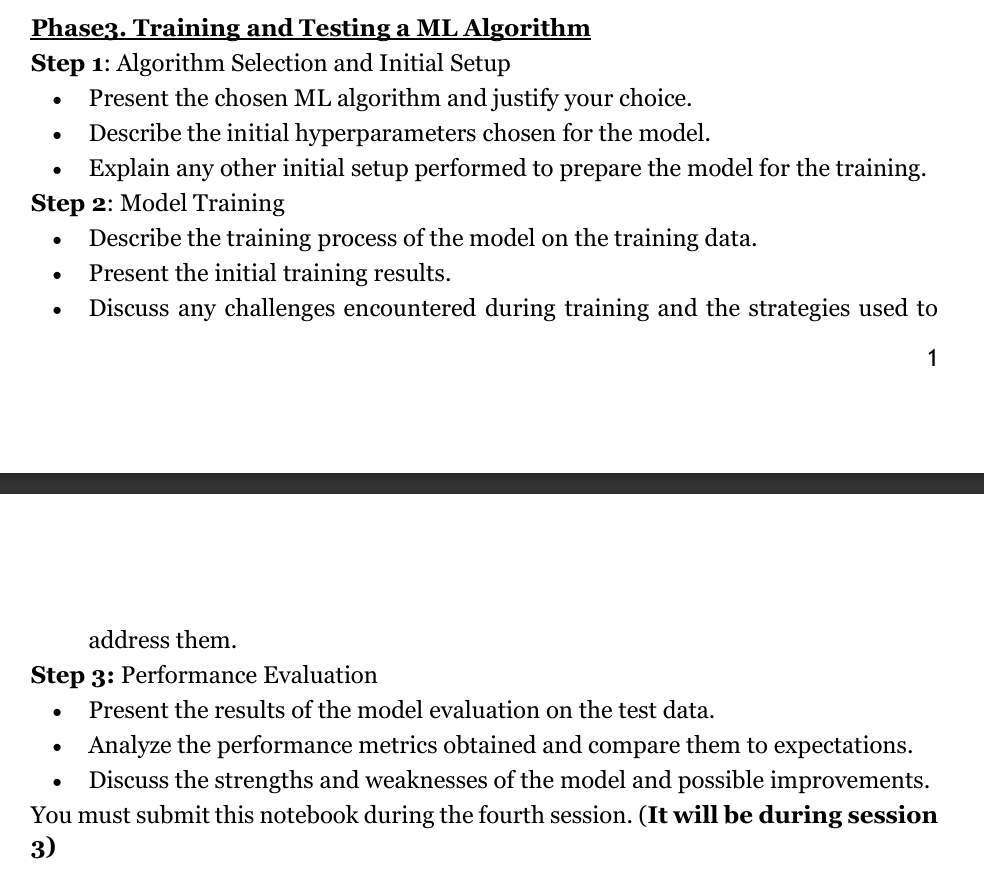

#### 1. Model training for price detection with Ridge

Regression for price detection with Ridge.

Gère très bien la régularisation avec beaucoup de colonnes. (Source : GPT)

In [29]:
# 1. Séparation des données
titles = wine_df['Title']
X = wine_df.drop(columns=['Price_clean', 'Title'])  # Features
y = wine_df['Price_clean']  # Target

X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# 2. Pipeline StandardScaler + Ridge
model_pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# 3. Hyperparameters Grid for Ridge
param_grid_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'ridge__fit_intercept': [True, False],  # Whether to fit intercept
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Solver algorithms
}

# 4. GridSearchCV
grid_search_ridge = GridSearchCV(
    estimator=model_pipeline_ridge,
    param_grid=param_grid_ridge,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimize for MSE
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

# 5. Fit the model
grid_search_ridge.fit(X_train_ridge, y_train_ridge)

# 6. Best hyperparameters
print("Best hyperparameters:", grid_search_ridge.best_params_)

# 7. Best model predictions
best_model_ridge = grid_search_ridge.best_estimator_
y_pred_ridge = best_model_ridge.predict(X_test_ridge)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best hyperparameters: {'ridge__alpha': 100.0, 'ridge__fit_intercept': True, 'ridge__solver': 'lsqr'}


In [31]:
# 5. Évaluation
print(f"MSE : {mean_squared_error(y_test_ridge, y_pred_ridge):.2f}")
print(f"MAE : {mean_absolute_error(y_test_ridge, y_pred_ridge):.2f}")
print(f"R² Score : {r2_score(y_test_ridge, y_pred_ridge):.2f}")

# 6. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test_ridge.values,
    'Prédit': y_pred_ridge
}).reset_index(drop=True)

print(results.head(10))  # Voir les 10 premières comparaisons


MSE : 977.60
MAE : 19.33
R² Score : 0.17
    Réel     Prédit
0   9.99  23.457962
1  14.99  -5.806825
2  12.99   9.071945
3  18.99  12.673623
4  64.99  71.232784
5   8.99   3.551001
6  13.99  36.477174
7  17.99  40.361800
8  24.99  31.022524
9  36.99  30.994967


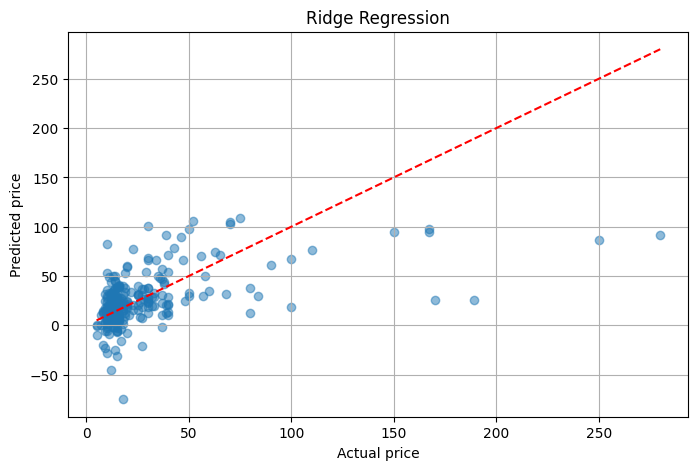

In [32]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_ridge, y_pred_ridge, alpha=0.5)
plt.plot([y_test_ridge.min(), y_test_ridge.max()], [y_test_ridge.min(), y_test_ridge.max()], 'r--')  # diagonale parfaite
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Ridge Regression')
plt.grid(True)
plt.show()

In [33]:
# 1. Data Preparation
X_ridge_pos = wine_df.drop(columns=['Price_clean', 'Title'])  # Features
y_ridge_pos = wine_df['Price_clean']  # Target (original scale)

# Log-transform the target (if needed for skewed prices)
y_ridge_pos_log = np.log(y_ridge_pos)

# Train-test split
X_train_ridge_pos, X_test_ridge_pos, y_train_log_ridge_pos, y_test_log_ridge_pos = train_test_split(
    X_ridge_pos, y_ridge_pos_log, test_size=0.2, random_state=42
)

# 2. Pipeline with Non-Negative Ridge
ridge_pos_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(positive=True))  # Force coefficients ≥ 0
])

# 3. Hyperparameter Grid
param_grid_ridge_pos = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'ridge__solver': ['auto', 'lbfgs']  # Solvers supporting positive=True
}

# 4. GridSearchCV
ridge_pos_search = GridSearchCV(
    estimator=ridge_pos_pipeline,
    param_grid=param_grid_ridge_pos,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# 5. Fit Model (on log-transformed target)
ridge_pos_search.fit(X_train_ridge_pos, y_train_log_ridge_pos)

# 6. Best Model Evaluation
best_ridge_pos = ridge_pos_search.best_estimator_
print("Best hyperparameters:", ridge_pos_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'ridge__alpha': 10.0, 'ridge__solver': 'auto'}


In [34]:
# Predictions (convert back from log scale)
y_pred_log_ridge_pos = best_ridge_pos.predict(X_test_ridge_pos)
y_pred_ridge_pos = np.exp(y_pred_log_ridge_pos)
y_test_ridge_pos = np.exp(y_test_log_ridge_pos)

# 7. Metrics
print(f"MSE: {mean_squared_error(y_test_log_ridge_pos, y_pred_ridge_pos):.2f}")
print(f"MAE: {mean_absolute_error(y_test_log_ridge_pos, y_pred_ridge_pos):.2f}")
print(f"R²: {r2_score(y_test_ridge_pos, y_pred_ridge_pos):.2f}")

# 9. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test_ridge_pos.values,
    'Prédit': y_pred_ridge_pos
}).reset_index(drop=True)

print(results.head(10))



MSE: 655.20
MAE: 19.73
R²: 0.27
    Réel     Prédit
0   9.99  12.773250
1  14.99  16.845658
2  12.99  17.844200
3  18.99  12.803610
4  64.99  53.576518
5   8.99   7.739732
6  13.99  24.054035
7  17.99  25.743374
8  24.99  19.070785
9  36.99  13.664118


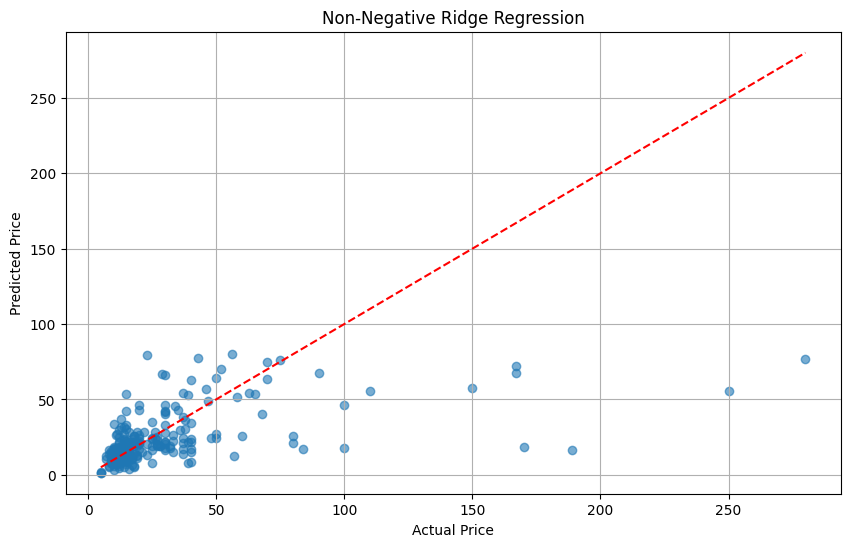

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_ridge_pos, y_pred_ridge_pos, alpha=0.6)
plt.plot([y_test_ridge_pos.min(), y_test_ridge_pos.max()], [y_test_ridge_pos.min(), y_test_ridge_pos.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Non-Negative Ridge Regression")
plt.grid(True)
plt.show()

#### 2. Model training with Linear Regression

Transformation log utilisée pour éviter les valeurs négatives.

In [36]:
# 1. Séparation des données
titles = wine_df['Title']
X_linear = wine_df.drop(columns=['Price_clean', 'Title'])  # ou autre cible
y_linear = wine_df['Price_clean']

In [37]:
# Transformation log (log des prix)
y_log_linear = np.log(y_linear)
X_train_linear, X_test_linear, y_train_log_linear, y_test_log_linear = train_test_split(X_linear, y_log_linear, test_size=0.2, random_state=42)

# 2. Pipeline StandardScaler + LinearRegression
model_pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

# 2. Hyperparameter grid
params_linear = {
    'linear__fit_intercept': [True, False],  # test with/without intercept
}

# 3. GridSearchCV
grid_search_linear = GridSearchCV(
    estimator=model_pipeline_linear,
    param_grid=params_linear,
    cv=5,                      # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # or 'neg_mean_absolute_error'
    verbose=1
)

# 4. Fit the model (on log-transformed y)
grid_search_linear.fit(X_train_linear, y_train_log_linear)

# 5. Best hyperparameters
print("Best hyperparameters:", grid_search_linear.best_params_)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'linear__fit_intercept': True}


In [38]:
# 6. Predictions (inverse log-transform)
y_pred_log_linear = grid_search_linear.predict(X_test_linear)

# 7. Transformation inverse : exp(log(y)) = y
y_pred_linear = np.exp(y_pred_log_linear)
y_test_linear = np.exp(y_test_log_linear)  # on remet aussi y_test à l'échelle originale

In [39]:
# 8. Évaluation
print(f"MSE : {mean_squared_error(y_test_linear, y_pred_linear):.2f}")
print(f"MAE : {mean_absolute_error(y_test_linear, y_pred_linear):.2f}")
print(f"R² Score : {r2_score(y_test_linear, y_pred_linear):.2f}")

# 9. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test_linear.values,
    'Prédit': y_pred_linear
}).reset_index(drop=True)

print(results.head(10))

MSE : 926.73
MAE : 14.57
R² Score : 0.21
    Réel     Prédit
0   9.99  16.047093
1  14.99  14.257361
2  12.99  13.872188
3  18.99  17.863356
4  64.99  64.534161
5   8.99   7.920448
6  13.99  28.009226
7  17.99  31.906959
8  24.99  20.571147
9  36.99  14.444433


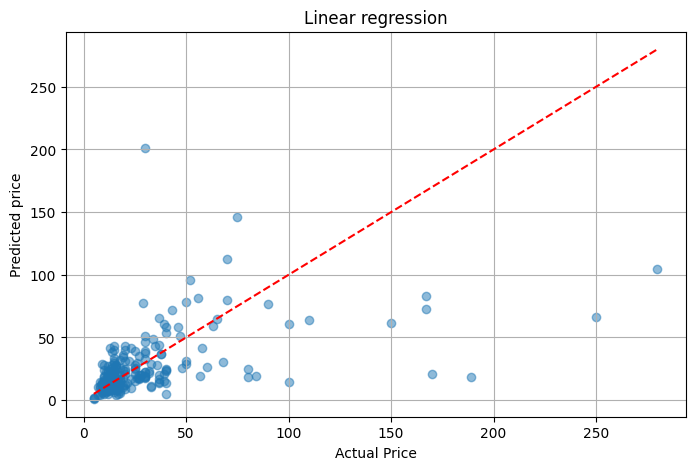

In [40]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_linear, y_pred_linear, alpha=0.5)
plt.plot([y_test_linear.min(), y_test_linear.max()], [y_test_linear.min(), y_test_linear.max()], 'r--')  # diagonale parfaite
plt.xlabel('Actual Price')
plt.ylabel('Predicted price')
plt.title('Linear regression')
plt.grid(True)
plt.show()

### 3. Training with Lasso


In [41]:
# 1. Data Preparation
X_lasso = wine_df.drop(columns=['Price_clean', 'Title'])  # Features
y_lasso = wine_df['Price_clean']  # Target

# Log-transform target (for skewed price data)
y_lasso_log = np.log(y_lasso)

# Train-test split
X_train_lasso, X_test_lasso, y_train_lasso_log, y_test_lasso_log = train_test_split(
    X_lasso, y_lasso_log, test_size=0.2, random_state=42
)

# 2. Pipeline with StandardScaler + Lasso
lasso_pipeline = Pipeline([
    ('scaler_lasso', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

# 3. Hyperparameter Grid for Lasso
param_grid_lasso = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'lasso__fit_intercept': [True, False],
    'lasso__selection': ['cyclic', 'random']  # Coefficient update method
}

# 4. GridSearchCV Setup
lasso_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid_lasso,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# 5. Model Training (on log-transformed target)
lasso_search.fit(X_train_lasso, y_train_lasso_log)

# 6. Best Model Evaluation
best_lasso = lasso_search.best_estimator_
print("Best Lasso hyperparameters:", lasso_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Lasso hyperparameters: {'lasso__alpha': 0.01, 'lasso__fit_intercept': True, 'lasso__selection': 'random'}


In [42]:
# Predictions (convert back from log scale)
y_pred_lasso_log = best_lasso.predict(X_test_lasso)
y_pred_lasso = np.exp(y_pred_lasso_log)  # Revert to original scale
y_test_lasso = np.exp(y_test_lasso_log)  # Actual values in original scale

# 7. Performance Metrics
print(f"MSE: {mean_squared_error(y_test_lasso, y_pred_lasso):.2f}")
print(f"MAE: {mean_absolute_error(y_test_lasso, y_pred_lasso):.2f}")
print(f"R²: {r2_score(y_test_lasso, y_pred_lasso):.2f}")

# 9. Comparaison valeurs réelles vs prédites
results = pd.DataFrame({
    'Réel': y_test_lasso.values,
    'Prédit': y_pred_lasso
}).reset_index(drop=True)

print(results.head(10))



MSE: 841.07
MAE: 12.09
R²: 0.29
    Réel     Prédit
0   9.99  12.944471
1  14.99  15.488506
2  12.99  16.046451
3  18.99  15.298741
4  64.99  57.734447
5   8.99   8.604287
6  13.99  12.726278
7  17.99  24.107620
8  24.99  19.001461
9  36.99  20.216990


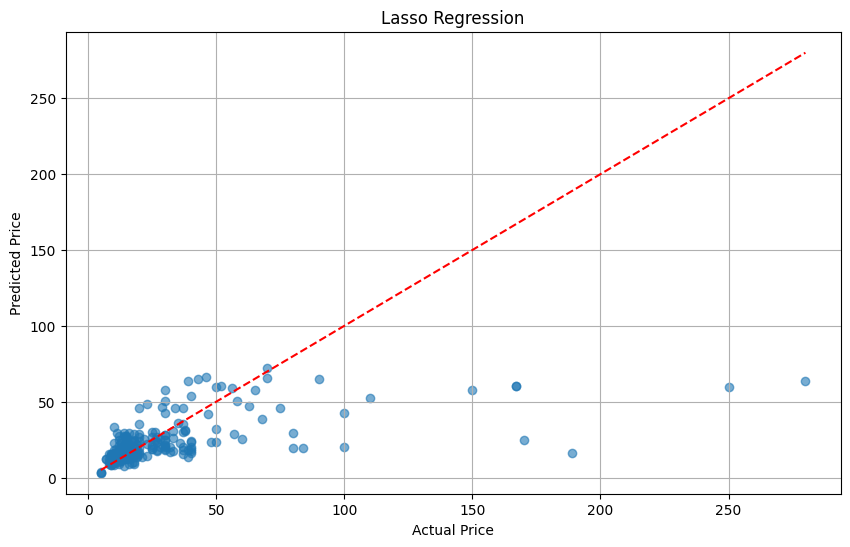

In [43]:
# 9. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_lasso, y_pred_lasso, alpha=0.6)
plt.plot([y_test_lasso.min(), y_test_lasso.max()], 
         [y_test_lasso.min(), y_test_lasso.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Lasso Regression")
plt.grid(True)
plt.show()


### 4. Comparing with an ensemble method (Stacking)

In [44]:
# 1. Data Preparation (same as before)
X = wine_df.drop(columns=['Price_clean', 'Title'])
y = wine_df['Price_clean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# (Optional) Log-transform
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# 2. Define base models with parameter grids
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('lr', LinearRegression())
]

# 3. Stacking model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(),  # meta-model
    cv=5  
)

# 4. Hyperparameter grid for GridSearchCV
param_grid = {
    #base model hyperparameters (use model__ prefix)
    'rf__n_estimators': [100, 200, 500],  # RandomForest
    'rf__max_depth': [None, 10, 30],      # Tree depth
    'rf__min_samples_split': [2, 5],      # Min samples to split a node
    'rf__max_features': ['sqrt', 0.8],   
    'gbr__n_estimators': [100, 200, 500],  # GradientBoosting
    'gbr__learning_rate': [0.01, 0.1],
    'gbr__max_depth': [3, 5],        # Tree depth
    'gbr__subsample': [0.8, 1.0],
    #meta-model hyperparameters
    'final_estimator__alpha': [0.1, 1.0, 10.0],  # Ridge regularisation
    'final_estimator__solver': ['auto', 'svd']   
}

# 5. GridSearchCV setup
stacking_search = GridSearchCV(
    estimator=stacking_model,
    param_grid=param_grid,
    cv=3,  # Outer CV folds
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# 6. Fit (on log-transformed y if needed)
stacking_search.fit(X_train, y_train_log)  # or y_train

# 7. Best model evaluation
best_stacking = stacking_search.best_estimator_
print("Best hyperparameters:", stacking_search.best_params_)

Fitting 3 folds for each of 5184 candidates, totalling 15552 fits
Best hyperparameters: {'final_estimator__alpha': 10.0, 'final_estimator__solver': 'svd', 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 500, 'gbr__subsample': 1.0, 'rf__max_depth': 30, 'rf__max_features': 0.8, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [45]:
# Predictions (convert back if using log)
y_pred_log = best_stacking.predict(X_test)
y_pred = np.exp(y_pred_log)  # Revert if log-transformed
y_test_actual = np.exp(y_test_log) if y_test_log is not None else y_test

print(f"MSE: {mean_squared_error(y_test_actual, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test_actual, y_pred):.2f}")
print(f"R²: {r2_score(y_test_actual, y_pred):.2f}")

MSE: 762.10
MAE: 12.10
R²: 0.35


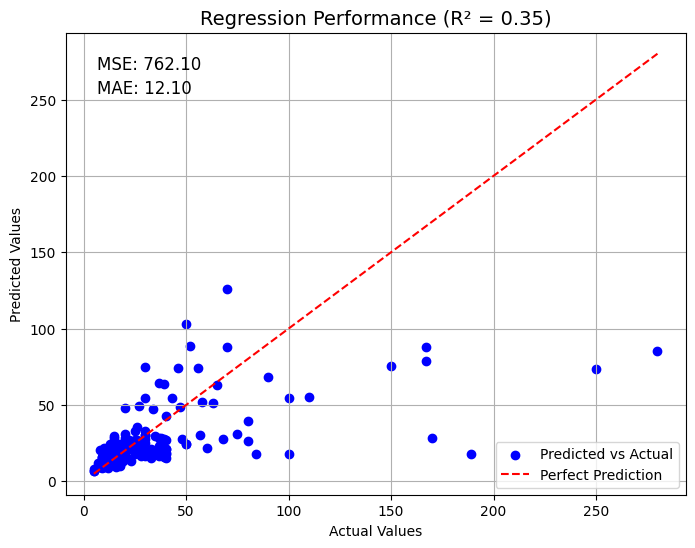

In [46]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')

plt.text(0.05, 0.95, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title(f'Regression Performance (R² = {r2:.2f})', fontsize=14)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()